# Document Classification Slides - IMDB

Predict the rating of a review, given it's text.

- Stephen W. Thomas
- Used for MMAI 891 and MMA/GMMA 865.
- Shows how to use a Pipeline

In [ ]:
import datetime
print(datetime.datetime.now())

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


# Read Data

In [4]:
df = pd.read_csv("../data/imdb.csv")

df.dropna(inplace=True)

df['rating'] = df['rating'].astype('str')
df['rating'] = df['rating'].str.replace(' ', '')

class_names = ['negative', 'positive']

# Take sample of data (for e.g., development purposes)?
df = df.sample(frac=0.50)

In [5]:
from sklearn.model_selection import train_test_split

X = df['en']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(20000,)

(20000,)

(5000,)

(5000,)

# Feature Engineering Pipeline

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import textstat

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV


def get_lexical(text):
    res = np.array([len(instance) for instance in text]).reshape(-1, 1)
    res = np.c_[res, np.array([textstat.syllable_count(instance) for instance in text]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.lexicon_count(instance) for instance in text]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.sentence_count(instance) for instance in text]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_reading_ease(instance) for instance in text]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_kincaid_grade(instance) for instance in text]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.gunning_fog(instance) for instance in text]).reshape(-1, 1)]
    return res

vectorizer = CountVectorizer(min_df=.01, max_df=.8, ngram_range=[1,3], max_features=300, stop_words='english')

union = FeatureUnion([('bow', vectorizer),
                      ('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                     ])

pipe = Pipeline([('features', union),  ('clf', DecisionTreeClassifier(random_state=223))])

# Modeling Fitting

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bow',
                                                 CountVectorizer(max_df=0.8,
                                                                 max_features=300,
                                                                 min_df=0.01,
                                                                 ngram_range=[1,
                                                                              3],
                                                                 stop_words='english')),
                                                ('get_lexical',
                                                 FunctionTransformer(func=<function get_lexical at 0x00000202E94DF158>))])),
                ('clf', DecisionTreeClassifier(random_state=223))])

In [8]:
# Get and save feature names for later (model interpretation)

bow_names = dict(pipe.named_steps['features'].transformer_list).get('bow').get_feature_names()
bow_names = ['bow_'+name for name in bow_names]
bow_names = [name.replace(' ', '_') for name in bow_names]
feature_names = bow_names + ['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning']

# Model Assessment

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = class_names))

[[1697  831]
 [ 756 1716]]
              precision    recall  f1-score   support

    negative       0.69      0.67      0.68      2528
    positive       0.67      0.69      0.68      2472

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



# Model Interpretation

In [10]:
clf_obj = pipe.named_steps['clf']

### Feature Importances

In [11]:
imp = pd.DataFrame({'Feature': feature_names, 'Importance': clf_obj.feature_importances_})
imp = imp.sort_values('Importance', ascending=False)
imp.head(20)

,Feature,Importance
11,bow_bad,0.086345
292,bow_worst,0.047892
108,bow_great,0.035615
277,bow_waste,0.029814
10,bow_awful,0.020377
300,len,0.017175
304,flesch,0.016605
306,gunning,0.016062
16,bow_best,0.015539
80,bow_excellent,0.015299


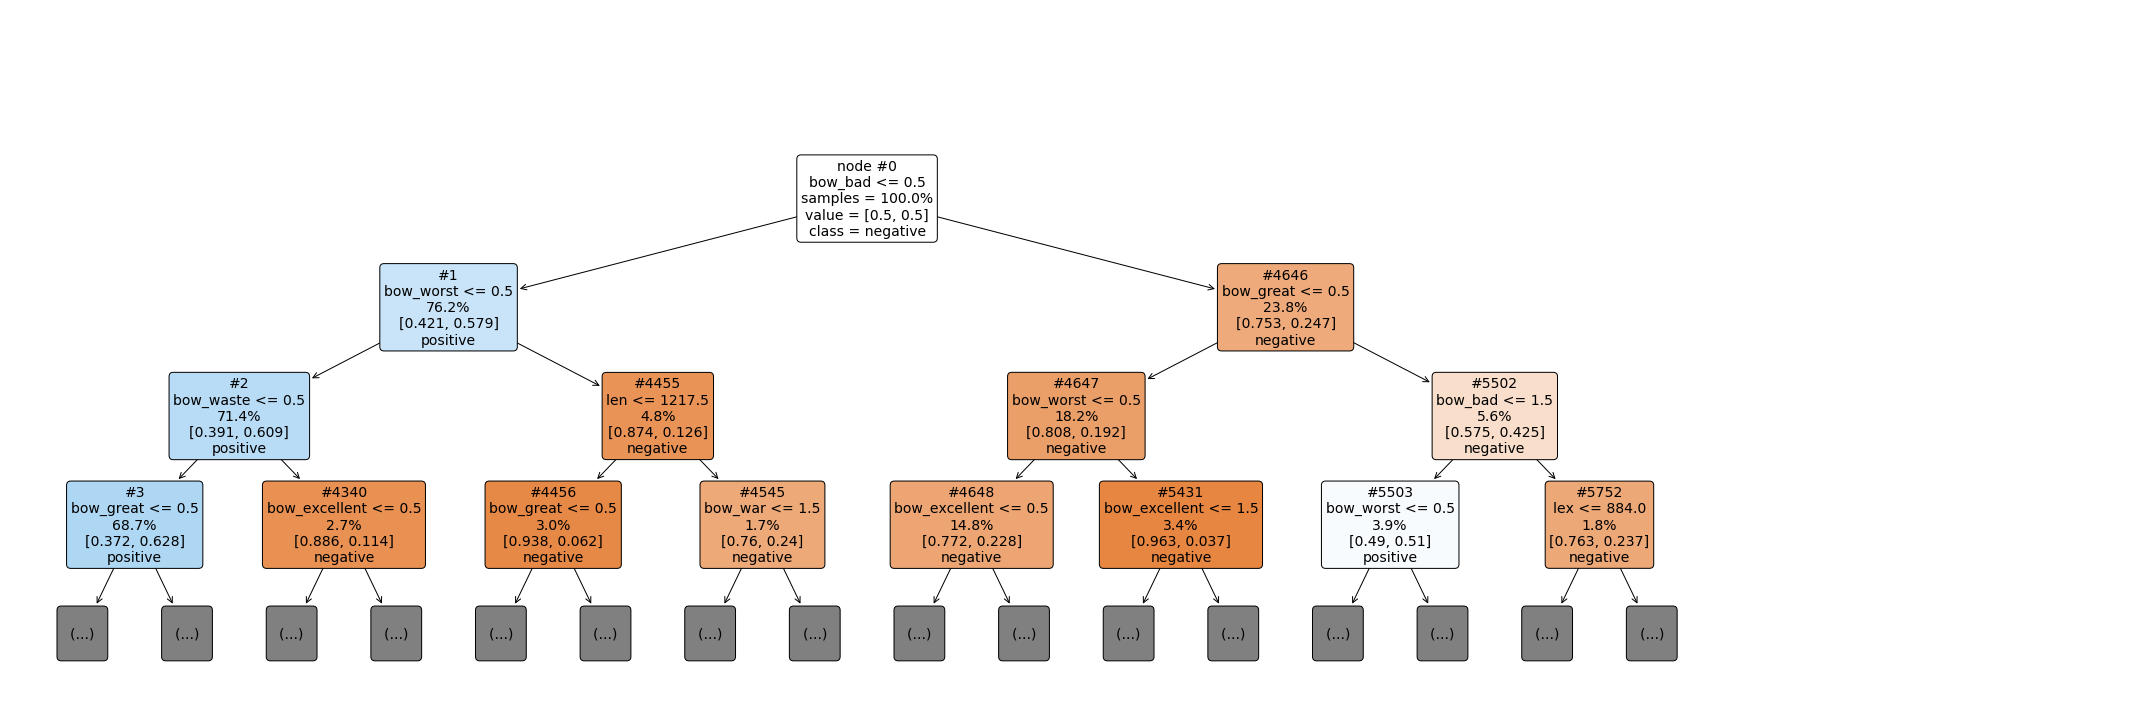

In [12]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree

plt.figure(figsize=[30,10]);
plot_tree(clf_obj, filled=True, feature_names = feature_names, class_names = class_names, 
          label='root', fontsize=14, impurity=False, rounded=True, proportion=True, max_depth=3, node_ids=True);
plt.tight_layout();

### Visually inspect training features

In [13]:
feature_processing_obj = pipe.named_steps['features']
type(feature_processing_obj)
f = feature_processing_obj.transform(X_train).toarray()
features_train = pd.DataFrame(f, columns = feature_names)

sklearn.pipeline.FeatureUnion

In [14]:
features_train.shape
features_train.head()
features_train.tail()

(20000, 307)

,bow_10,bow_absolutely,bow_acting,bow_action,bow_actor,bow_actors,bow_actually,bow_american,bow_audience,bow_away,...,bow_years,bow_yes,bow_young,len,syll,lex,sent,flesch,kincaid,gunning
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,3423.0,879.0,539.0,16.0,37.27,16.4,19.42
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,810.0,194.0,137.0,10.0,74.49,6.3,8.11
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1232.0,291.0,213.0,9.0,64.34,10.2,11.17
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,558.0,141.0,102.0,7.0,73.58,6.6,7.02
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,616.0,157.0,113.0,3.0,50.13,15.6,16.50


,bow_10,bow_absolutely,bow_acting,bow_action,bow_actor,bow_actors,bow_actually,bow_american,bow_audience,bow_away,...,bow_years,bow_yes,bow_young,len,syll,lex,sent,flesch,kincaid,gunning
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1201.0,303.0,240.0,12.0,76.56,7.6,9.33
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1707.0,418.0,309.0,8.0,49.22,16.0,17.38
19997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,290.0,72.0,58.0,3.0,85.73,6.1,8.41
19998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,939.0,218.0,180.0,13.0,91.31,4.0,6.63
19999,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,661.0,163.0,119.0,6.0,68.30,8.7,10.27


#### Exploring the BOW

In [15]:
from statistics import mean, stdev

y_df = pd.DataFrame(y_train, columns=["rating"])
y_df = y_df.reset_index(drop=True)
features = pd.concat([features_train, y_df], axis=1)

neg = features[features['rating'] == 'negative']
pos = features[features['rating'] == 'positive']

stats = pd.DataFrame(columns=['feature_name', 'sum', 'neg_sum', 'neg_per', 'pos_sum', 'pos_per', 'neg_docs', 'pos_docs', 'neg_mean', 'pos_mean', 'abs_diff_mean'])

for word in feature_names:
    
    if "bow_" not in word:
        continue
        
    i = list(feature_names).index(word)
    
    neg_sum = sum(neg[word])
    pos_sum = sum(pos[word])
    
    all_sum = neg_sum + pos_sum
    
    if all_sum == 0:
        print(word)
        all_sum = 1
    
    neg_per = neg_sum / all_sum
    pos_per = pos_sum / all_sum

    neg_docs = sum(neg[word]>0)
    pos_docs = sum(pos[word]>0)
    
    neg_mean = 0
    if neg_docs > 0:    
        neg_mean = mean(neg[word])
        
    pos_mean = 0
    if pos_docs > 0:
        pos_mean = mean(pos[word])

    abs_diff_mean = abs(neg_mean - pos_mean)
    
    # TODO: percent diff? likelihood?
    
    stats.loc[len(stats)] = [word.replace('bow_',""), all_sum, neg_sum, neg_per, pos_sum, pos_per, neg_docs, pos_docs, neg_mean, pos_mean, abs_diff_mean]

In [16]:
stats.sort_values(by=['neg_per'], ascending=False).head(10).round(2)

,feature_name,sum,neg_sum,neg_per,pos_sum,pos_per,neg_docs,pos_docs,neg_mean,pos_mean,abs_diff_mean
277,waste,1119.0,1040.0,0.93,79.0,0.07,945,77,0.10,0.01,0.10
292,worst,2142.0,1960.0,0.92,182.0,0.08,1608,166,0.20,0.02,0.18
10,awful,1361.0,1228.0,0.90,133.0,0.10,1028,121,0.12,0.01,0.11
250,terrible,1329.0,1142.0,0.86,187.0,0.14,915,166,0.11,0.02,0.10
244,stupid,1414.0,1182.0,0.84,232.0,0.16,909,192,0.12,0.02,0.09
291,worse,1156.0,963.0,0.83,193.0,0.17,836,183,0.10,0.02,0.08
22,boring,1441.0,1169.0,0.81,272.0,0.19,963,251,0.12,0.03,0.09
11,bad,7456.0,5974.0,0.80,1482.0,0.20,3588,1179,0.60,0.15,0.45
200,poor,1569.0,1236.0,0.79,333.0,0.21,1009,306,0.12,0.03,0.09
246,supposed,1165.0,904.0,0.78,261.0,0.22,774,237,0.09,0.03,0.06


In [17]:
stats.sort_values(by=['pos_per'], ascending=False).head(10).round(2)

,feature_name,sum,neg_sum,neg_per,pos_sum,pos_per,neg_docs,pos_docs,neg_mean,pos_mean,abs_diff_mean
80,excellent,1621.0,292.0,0.18,1329.0,0.82,272,1132,0.03,0.13,0.10
288,wonderful,1220.0,222.0,0.18,998.0,0.82,210,835,0.02,0.10,0.08
187,perfect,1268.0,279.0,0.22,989.0,0.78,247,831,0.03,0.10,0.07
158,loved,1199.0,270.0,0.23,929.0,0.77,242,788,0.03,0.09,0.07
13,beautiful,1696.0,474.0,0.28,1222.0,0.72,417,1011,0.05,0.12,0.07
108,great,7234.0,2093.0,0.29,5141.0,0.71,1657,3372,0.21,0.51,0.31
189,performances,1418.0,441.0,0.31,977.0,0.69,409,868,0.04,0.10,0.05
16,best,5110.0,1637.0,0.32,3473.0,0.68,1368,2522,0.16,0.35,0.18
275,war,1803.0,582.0,0.32,1221.0,0.68,378,633,0.06,0.12,0.06
55,definitely,1222.0,409.0,0.33,813.0,0.67,377,725,0.04,0.08,0.04


In [18]:
r, _ = stats.shape
num = 10
middle = round((r / 2) - (num / 2))

stats.sort_values(by=['pos_per'], ascending=False).iloc[round(middle-num/2):round(middle+num/2),:].round(2)

,feature_name,sum,neg_sum,neg_per,pos_sum,pos_per,neg_docs,pos_docs,neg_mean,pos_mean,abs_diff_mean
279,watched,1797.0,907.0,0.50,890.0,0.50,809,771,0.09,0.09,0.00
72,ending,1884.0,951.0,0.50,933.0,0.50,778,785,0.10,0.09,0.00
133,kids,1459.0,737.0,0.51,722.0,0.49,516,489,0.07,0.07,0.00
151,long,2691.0,1366.0,0.51,1325.0,0.49,1152,1152,0.14,0.13,0.00
81,face,1363.0,697.0,0.51,666.0,0.49,606,575,0.07,0.07,0.00
38,character,5600.0,2872.0,0.51,2728.0,0.49,1920,1877,0.29,0.27,0.01
114,having,1952.0,1002.0,0.51,950.0,0.49,881,822,0.10,0.10,0.01
39,characters,5754.0,2961.0,0.51,2793.0,0.49,2066,2003,0.30,0.28,0.02
190,person,1297.0,668.0,0.52,629.0,0.48,568,519,0.07,0.06,0.00
99,gets,2505.0,1292.0,0.52,1213.0,0.48,1076,1013,0.13,0.12,0.01


In [19]:
stats[stats['feature_name'] == 'bad']

,feature_name,sum,neg_sum,neg_per,pos_sum,pos_per,neg_docs,pos_docs,neg_mean,pos_mean,abs_diff_mean
11,bad,7456.0,5974.0,0.801234,1482.0,0.198766,3588,1179,0.597101,0.148274,0.448827
